# Section 1: Importing Packages and Loading Data

In [2]:
import numpy as np
import pandas as pd
seed = 69 # set random seed for whole document

# Graph plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Displaying dataframes
from IPython.display import display

# Natural Language Processing Thingamajibs
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from gensim.models import Word2Vec, word2vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import gensim

# Classifiers
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC

# Metrics to score classifiers
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, log_loss

# Data splitting, CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
[nltk_data] Downloading package stopwords to /Users/ns/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import pickle

In [4]:
# Load CSV file
df = pd.read_csv('complaints.csv')

/Users/ns/miniforge3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3398: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Section 1.1: Data Cleaning

In [5]:
# Column Cleaning First. Columns are super nastily named
df.rename(columns={'Date received':'DATE_RECEIVED',
                  'Product':'PRODUCT',
                  'Sub-product':'SUB_PRODUCT',
                  'Issue':'ISSUE',
                  'Sub-issue':'SUB_ISSUE',
                  'Consumer complaint narrative':'CONSUMER_COMPLAINT_NARRATIVE',
                  'Company public response':'COMPANY_PUBLIC_RESPONSE',
                   'Company':'COMPANY',
                   'State':'STATE',
                   'ZIP code':'ZIP_CODE',
                   'Tags':'TAGS',
                   'Consumer consent provided?':'CONSUMER_CONSENT_PROVIDED',
                   'Subbmited via':'SUBMITTED_VIA',
                   'Date sent to company':'DATE_SENT_TO_COMPANY',
                   'Company response to consumer':'COMPANY_RESPONSE_TO_CONSUMER',
                   'Timely response?':'TIMELY_RESPONSE',
                   'Consumer disputed?':'CONSUMER_DISPUTED',
                   'Complaint ID':'COMPLAINT_ID'
                  }, inplace=True)

# Section 1.1.1: Dropping all rows that do not have Customer Complaint entries in them

In [6]:
# Since we just want to do text classification with an associated label
# We only keep rows that have customer complaints in them

In [7]:
df.dropna(axis=0, subset=['CONSUMER_COMPLAINT_NARRATIVE'], 
          inplace=True)

# Section 1.1.2: Subsetting Dataframe for Text Multi-Classification Problem

In [8]:
# Subsetting dataframe into columns useful for our text multi-classification problem
df_product_and_complaint = df[['PRODUCT', 'CONSUMER_COMPLAINT_NARRATIVE']]

# Renaming columns to something easier
df_product_and_complaint.rename(columns={'CONSUMER_COMPLAINT_NARRATIVE':'CONSUMER_COMPLAINT'},inplace=True) 
df.rename(columns={'CONSUMER_COMPLAINT_NARRATIVE':'CONSUMER_COMPLAINT'},inplace=True) 

/Users/ns/miniforge3/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [9]:
# Pickling subsetted dataframe
with open('df_product_and_complaint.pickle', 'wb') as to_write:
    pickle.dump(df_product_and_complaint, to_write)

In [10]:
# Loading pickled subsetted dataframe
with open('df_product_and_complaint.pickle', 'rb') as to_read:
    df_product_and_complaint = pickle.load(to_read)

# Section 2: Understanding/Cleaning  Data

In [11]:
# Checking our dataframe
df_product_and_complaint.info()

# No null values in each column

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1290749 entries, 112 to 3583113
Data columns (total 2 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   PRODUCT             1290749 non-null  object
 1   CONSUMER_COMPLAINT  1290749 non-null  object
dtypes: object(2)
memory usage: 29.5+ MB


Reducing the entries to avoid crashes

In [12]:
df_product_and_complaint.head(5)

,PRODUCT,CONSUMER_COMPLAINT
112,"Credit reporting, credit repair services, or o...",IDENTITY THEFT XX/XX/XXXXXXXX XXXX XXXX XXXX X...
116,Checking or savings account,"In XX/XX/2023, I received a letter from Citi, ..."
160,Credit card or prepaid card,My minimum payment for my Fortiva Retail Credi...
164,Mortgage,Wells Fargo transferred servicing of my loan t...
178,"Credit reporting, credit repair services, or o...","My name is XXXX XXXX, this complaint is not ma..."


# Section 2.1: Exploring Consumer Complaints

In [13]:
# # What do a few of the entries in the consumer complaint section look like?

# df_credit_card = df_product_and_complaint[df_product_and_complaint['PRODUCT'] == 'Credit card']
# df_credit_card.rename(columns={'PRODUCT': 'Credit card'}, inplace=True)

#for complaint in df_credit_card.CONSUMER_COMPLAINT[:2]:
#    print(complaint)
#    print('\n')

# Section 2.2: Exploring Product

In [14]:
# Exploring the number of mutli-class categories we have
print('--------------')
print('Categories in PRODUCT column:')
print('--------------\n')
print(df_product_and_complaint['PRODUCT'].unique(), '\n')
print('--------------')
print('# of unique categories: ', df_product_and_complaint['PRODUCT'].nunique())
print('--------------')

--------------
Categories in PRODUCT column:
--------------

['Credit reporting, credit repair services, or other personal consumer reports'
 'Checking or savings account' 'Credit card or prepaid card' 'Mortgage'
 'Debt collection' 'Vehicle loan or lease'
 'Payday loan, title loan, or personal loan'
 'Money transfer, virtual currency, or money service' 'Student loan'
 'Credit reporting' 'Consumer Loan' 'Bank account or service'
 'Payday loan' 'Credit card' 'Prepaid card' 'Money transfers'
 'Other financial service' 'Virtual currency'] 

--------------
# of unique categories:  18
--------------


Some of the categories are repeated.

'Credit card' vs 'Credit card or prepaid card'

'Prepaid card' vs 'Credit card or prepaid card'

'Credit reporting' vs 'Credit reporting, credit repair services, or other personal consumer reports'

'Money transfers' vs 'Money transfer, virtual currency, or money service'

'Payday loan' vs 'Payday loan, title loan, or personal loan'

'Virtual currency' vs 'Money transfer, virtual currency, or money service' 'Money transfers'

There seems to be some sort of overlap between the categories, so combining these togethr

# Section 2.2.1: Data Visualization on Categories in PRODUCT

/var/folders/rv/ky3c0tn96k9dns7prp47l12r0000gn/T/ipykernel_13517/2802096184.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transparency" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('freq_of_uncombined_class.png', transparency=True)


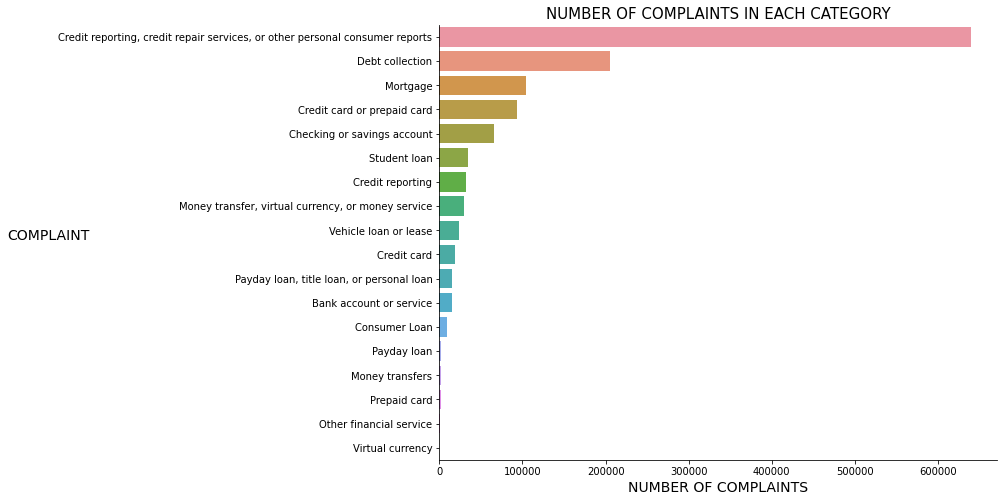

In [15]:
fig, ax = plt.subplots(figsize=(10,8))

ax = sns.countplot(y='PRODUCT', 
                   data=df_product_and_complaint, 
                   order=df_product_and_complaint['PRODUCT'].value_counts().index)

ax.set_title('NUMBER OF COMPLAINTS IN EACH CATEGORY',size=15)

# Setting labels
# Dealing with y-labels
ax.set_ylabel('COMPLAINT', rotation=0, size=14, labelpad=10)
              
# Dealing with x-labels
ax.set_xlabel('NUMBER OF COMPLAINTS', size=14)

sns.despine()
            
plt.savefig('freq_of_uncombined_class.png', transparency=True)

In [16]:
print('Number of rows in Dataframe: ', len(df_product_and_complaint))
# way too large

Number of rows in Dataframe:  1290749


# Section 2.2.2: DataFrame Reduction
Section 2.2.2.1: Category Dropping

In [17]:
# Pre-drop category value_counts
df_product_and_complaint.PRODUCT.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    639573
Debt collection                                                                 205227
Mortgage                                                                        103766
Credit card or prepaid card                                                      93071
Checking or savings account                                                      66204
Student loan                                                                     34705
Credit reporting                                                                 31587
Money transfer, virtual currency, or money service                               30198
Vehicle loan or lease                                                            23049
Credit card                                                                      18838
Payday loan, title loan, or personal loan                                        15184
Bank account or service                    

In [18]:
# Dropping rows with the aggregated columns
df_product_and_complaint.drop(
    df_product_and_complaint[
    df_product_and_complaint.PRODUCT == 
    'Credit reporting, credit repair services, or other personal consumer reports'].index, 
    inplace=True) # credit_aggregated

df_product_and_complaint.drop(
    df_product_and_complaint[
    df_product_and_complaint.PRODUCT == 
    'Credit card or prepaid card'].index, 
    inplace=True) # cred_or_prepaid

df_product_and_complaint.drop(
    df_product_and_complaint[
    df_product_and_complaint.PRODUCT == 
    'Money transfer, virtual currency, or money service'].index, 
    inplace=True) # money_virtual_service

df_product_and_complaint.drop(
    df_product_and_complaint[
    df_product_and_complaint.PRODUCT == 
    'Payday loan, title loan, or personal loan'].index, 
    inplace=True) # payday_title_personal_loan

Visualizing Leftover Categories (after dropping the ones stated above)

Text(0.5, 0, 'NUMBER OF COMPLAINTS')

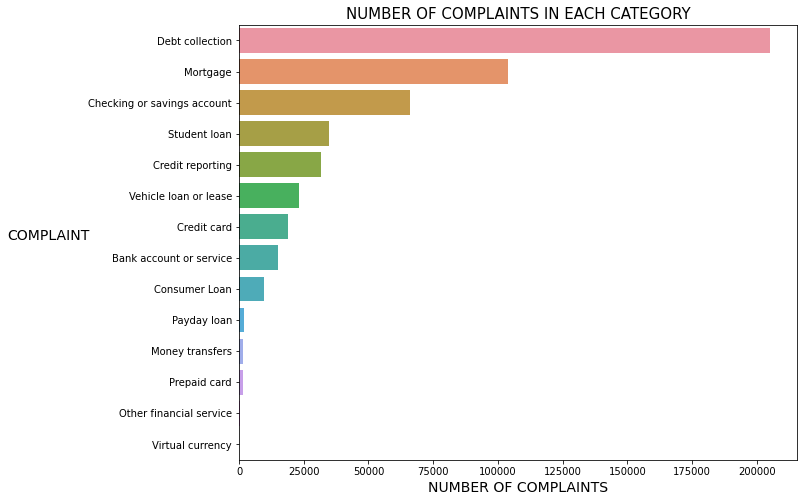

In [19]:
fig, ax = plt.subplots(figsize=(10,8))

ax = sns.countplot(y='PRODUCT', 
                   data=df_product_and_complaint, 
                   order=df_product_and_complaint['PRODUCT'].value_counts().index)

ax.set_title('NUMBER OF COMPLAINTS IN EACH CATEGORY',size=15)

# Setting labels
# Dealing with y-labels
ax.set_ylabel('COMPLAINT', rotation=0, labelpad=40, size=14)
              
# Dealing with x-labels
ax.set_xlabel('NUMBER OF COMPLAINTS', size=14)

In [20]:
# Checking Length of df now
df_product_and_complaint.info()

# It's still quite a sizeable amount that my computer can't take. So we have to drop more.
# We want to reduce it to less than 50k entries

<class 'pandas.core.frame.DataFrame'>
Int64Index: 512723 entries, 116 to 3583113
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   PRODUCT             512723 non-null  object
 1   CONSUMER_COMPLAINT  512723 non-null  object
dtypes: object(2)
memory usage: 27.9+ MB


In [21]:
df_product_and_complaint.PRODUCT.value_counts()

Debt collection                205227
Mortgage                       103766
Checking or savings account     66204
Student loan                    34705
Credit reporting                31587
Vehicle loan or lease           23049
Credit card                     18838
Bank account or service         14885
Consumer Loan                    9461
Payday loan                      1746
Money transfers                  1497
Prepaid card                     1450
Other financial service           292
Virtual currency                   16
Name: PRODUCT, dtype: int64

## Section 2.2.2.2: Combining Categories

In [22]:
## Combining Loans together to make this a simplier classification problem

df_product_and_complaint.replace('Student loan', 'Loan', inplace=True)
df_product_and_complaint.replace('Consumer Loan', 'Loan', inplace=True)
df_product_and_complaint.replace('Payday loan', 'Loan', inplace=True)
df_product_and_complaint.replace('Vehicle loan or lease', 'Loan', inplace=True)

# Placing Virtual currency into other financial service
df_product_and_complaint.replace('Virtual currency', 'Other financial service', inplace=True)

## Section 2.2.2.3: Leftover Categories Dataframe Reduction

In [23]:
df_product_and_complaint.PRODUCT.value_counts()

Debt collection                205227
Mortgage                       103766
Loan                            68961
Checking or savings account     66204
Credit reporting                31587
Credit card                     18838
Bank account or service         14885
Money transfers                  1497
Prepaid card                     1450
Other financial service           308
Name: PRODUCT, dtype: int64

In [24]:
df_product_and_complaint.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 512723 entries, 116 to 3583113
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   PRODUCT             512723 non-null  object
 1   CONSUMER_COMPLAINT  512723 non-null  object
dtypes: object(2)
memory usage: 27.9+ MB


In [25]:
# Need to reduce all categories by 90%

percentage_reduction = 0.9

# Debt Collection Reduction
df_product_and_complaint_reduced = \
df_product_and_complaint.drop(
    df_product_and_complaint[df_product_and_complaint['PRODUCT'] == 'Debt collection'].sample(frac=percentage_reduction).index)

# Mortgage Reduction
df_product_and_complaint_reduced = \
df_product_and_complaint_reduced.drop(
    df_product_and_complaint_reduced[
        df_product_and_complaint_reduced['PRODUCT'] == 'Mortgage'].sample(frac=percentage_reduction).index)

# Loan
df_product_and_complaint_reduced = \
df_product_and_complaint_reduced.drop(
    df_product_and_complaint_reduced[
        df_product_and_complaint_reduced['PRODUCT'] == 'Loan'].sample(frac=percentage_reduction).index)

# Credit reporting
df_product_and_complaint_reduced = \
df_product_and_complaint_reduced.drop(
    df_product_and_complaint_reduced[
        df_product_and_complaint_reduced['PRODUCT'] == 'Credit reporting'].sample(frac=percentage_reduction).index)

# Credit card
df_product_and_complaint_reduced = \
df_product_and_complaint_reduced.drop(
    df_product_and_complaint_reduced[
        df_product_and_complaint_reduced['PRODUCT'] == 'Credit card'].sample(frac=percentage_reduction).index)

# Checking or savings account
df_product_and_complaint_reduced = \
df_product_and_complaint_reduced.drop(
    df_product_and_complaint_reduced[
        df_product_and_complaint_reduced['PRODUCT'] == 'Checking or savings account'].sample(frac=percentage_reduction).index)

# Bank account or service
df_product_and_complaint_reduced = \
df_product_and_complaint_reduced.drop(
    df_product_and_complaint_reduced[
        df_product_and_complaint_reduced['PRODUCT'] == 'Bank account or service'].sample(frac=percentage_reduction).index)

# # Money transfers (too little to be reduced)
# df_product_and_complaint_reduced = \
# df_product_and_complaint_reduced.drop(
#     df_product_and_complaint_reduced[
#         df_product_and_complaint_reduced['PRODUCT'] == 'Money transfers'].sample(frac=.9).index)

# # Prepaid card (too little to be reduced)
# df_product_and_complaint_reduced = \
# df_product_and_complaint_reduced.drop(
#     df_product_and_complaint_reduced[
#         df_product_and_complaint_reduced['PRODUCT'] == 'Prepaid card'].sample(frac=.9).index)

# # Other financial service (too little to be reduced)
# df_product_and_complaint_reduced = \
# df_product_and_complaint_reduced.drop(
#     df_product_and_complaint_reduced[
#         df_product_and_complaint_reduced['PRODUCT'] == 'Other financial service'].sample(frac=.9).index)

In [26]:
df_product_and_complaint_reduced.PRODUCT.value_counts()

Debt collection                20523
Mortgage                       10377
Loan                            6896
Checking or savings account     6620
Credit reporting                3159
Credit card                     1884
Money transfers                 1497
Bank account or service         1489
Prepaid card                    1450
Other financial service          308
Name: PRODUCT, dtype: int64

In [27]:
df_product_and_complaint_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54203 entries, 164 to 3582768
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   PRODUCT             54203 non-null  object
 1   CONSUMER_COMPLAINT  54203 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [28]:
# Exploring the new number of mutli-class categories we have
print('--------------')
print('Categories in PRODUCT column:')
print('--------------\n')
print(df_product_and_complaint_reduced['PRODUCT'].unique(), '\n')
print('--------------')
print('# of unique categories: ', df_product_and_complaint_reduced['PRODUCT'].nunique())
print('--------------')

# Down to 10 classes

--------------
Categories in PRODUCT column:
--------------

['Mortgage' 'Checking or savings account' 'Loan' 'Debt collection'
 'Bank account or service' 'Credit card' 'Credit reporting' 'Prepaid card'
 'Money transfers' 'Other financial service'] 

--------------
# of unique categories:  10
--------------


## Section 2.2.3: Data Visualizing on newly combined classes

/var/folders/rv/ky3c0tn96k9dns7prp47l12r0000gn/T/ipykernel_13517/4005488244.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transparency" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('freq_of_removed_classes_and_reduced_observations.png', transparency=True)


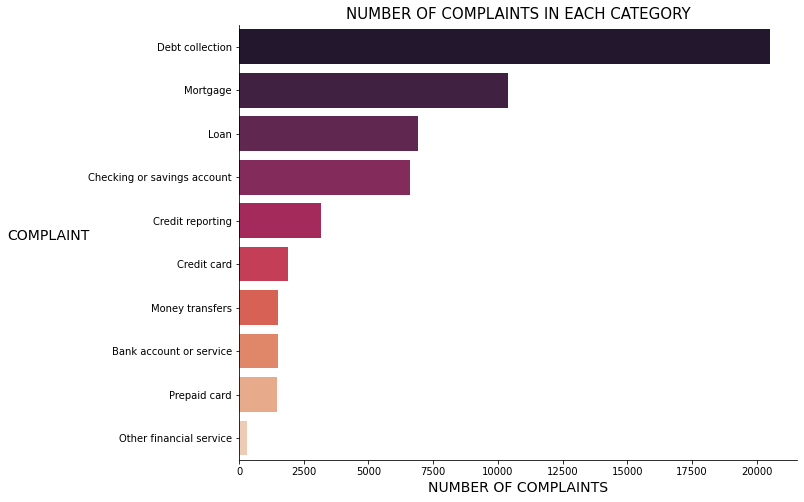

In [29]:
fig, ax = plt.subplots(figsize=(10,8))

ax = sns.countplot(y='PRODUCT', 
                   data=df_product_and_complaint_reduced, 
                   order=df_product_and_complaint_reduced['PRODUCT'].value_counts().index,
                   palette='rocket'        # change the color of this graph LATER
                  )

ax.set_title('NUMBER OF COMPLAINTS IN EACH CATEGORY',size=15)

# Setting labels
# Dealing with y-labels
ax.set_ylabel('COMPLAINT', rotation=0, labelpad=40, size=14)
              
# Dealing with x-labels
ax.set_xlabel('NUMBER OF COMPLAINTS', size=14)

sns.despine()
plt.savefig('freq_of_removed_classes_and_reduced_observations.png', transparency=True)

See from the graph that there lies a major class imbalance (again)

Have to deal with this when using the model for prediction

## Section 2.2.4: Label Encoding Categories

In [30]:
# Applying encoding to the PRODUCT column
df_product_and_complaint_reduced['PRODUCT_ID'] = df_product_and_complaint_reduced['PRODUCT'].factorize()[0] 

#.factorize[0] arranges the index of each encoded number accordingly to the 
# index of your categorical variables in the PRODUCT column


# Creates a dataframe of the PRODUCT to their respective PRODUCT_ID
category_id_df = df_product_and_complaint_reduced[['PRODUCT', 'PRODUCT_ID']].drop_duplicates()


# Dictionaries for future use. Creating our cheatsheets for what each encoded label represents.
category_to_id = dict(category_id_df.values) # Creates a PRODUCT: PRODUCT_ID key-value pair
id_to_category = dict(category_id_df[['PRODUCT_ID', 'PRODUCT']].values)  # Creates a PRODUCT_ID: PRODUCT key-value pair

# New dataframe
df_product_and_complaint_reduced.head(10)

,PRODUCT,CONSUMER_COMPLAINT,PRODUCT_ID
164,Mortgage,Wells Fargo transferred servicing of my loan t...,0
1676,Checking or savings account,On XX/XX/XXXX of XXXX I went to a US BANK bra...,1
1993,Mortgage,"XX/XX/XXXX XXXX XXXX XXXX XXXX XXXX, XXXX, CO ...",0
3099,Checking or savings account,"XX/XX/23, a deposit of {$170.00} for medicatio...",1
5651,Checking or savings account,Citibank recently had to change the class of s...,1
8012,Loan,I am XXXX XXXX behind on my car note but have ...,2
8077,Checking or savings account,my name is XXXX XXXX this complaint is for cas...,1
8539,Debt collection,AS OF XX/XX/XXXX I HAVE NOTICED FRAUD ACCOUNT ...,3
8795,Loan,"I purchased a new vehicle on XX/XX/2022, finan...",2
9022,Checking or savings account,My account is set up to limit communications t...,1


In [31]:
# Still the same length as per the original df.
len(df_product_and_complaint_reduced)

54203

Time to move on to the next step -- cleaning the fricken text data

In [32]:
## Pickling reduced dataframe
#with open('df_product_and_complaint_reduced.pickle', 'wb') as to_write:
#    pickle.dump(df_product_and_complaint_reduced, to_write)

In [33]:
# Loading Pickled DataFrame
with open('df_product_and_complaint_reduced.pickle', 'rb') as to_read:
    df_product_and_complaint_reduced = pickle.load(to_read)

In [34]:
# Reviewing Loaded Dataframe
print(df_product_and_complaint_reduced.info())
print('--------------------------------------------------------------------------------------')
print(df_product_and_complaint_reduced.head().to_string())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54203 entries, 551 to 3583113
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   PRODUCT             54203 non-null  object
 1   CONSUMER_COMPLAINT  54203 non-null  object
 2   PRODUCT_ID          54203 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None
--------------------------------------------------------------------------------------
              PRODUCT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

## Section 2.2.5: Text Pre-Processing 

In [35]:
# Looking at a sample text
sample_complaint = list(df_product_and_complaint_reduced.CONSUMER_COMPLAINT[:5])[4]

# Converting to a list for TfidfVectorizer to use
list_sample_complaint = []
list_sample_complaint.append(sample_complaint)
list_sample_complaint

['After the first complaint I filed, was told to bad Wells Fargos records of our account show that no XXXX  XXXX payments were made. I have been able to prove they had been made. Not denying it just sorry but its not enough. Ok, Im dealing with and talking about a company that has been sued and fined 20+ times. Now the Cfpb sends all complaints about Wells Fargo to Wells Fargo! Ive been able to prove the XXXX  XXXX payments, sorry but again there records prove different, Oh they say they only go back 7 years. So Wells Fargo can only go back 7 years and XXXX XXXX only to XXXX. This all changed when XXXX XXXX saw the bubble burst coming and began insulating themselves from any lawsuits in the future, by claiming they were never aware and if they were they were not willing and knowingly involved with Wells Fargo and XXXX payments through XXXX XXXX. I have said since I filed the original complaint. I know we made the payments and we were not behind. I have said since the beginning, I took 

In [36]:
# Observing what words are extracted from a TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf3 = TfidfVectorizer(stop_words='english')
check3 = tf_idf3.fit_transform(list_sample_complaint)

print(tf_idf3.get_feature_names())

['20', '22', '30', '3rd', 'able', 'account', 'actions', 'activities', 'actual', 'add', 'allowed', 'asking', 'aware', 'bad', 'bank', 'bankruptcy', 'basically', 'began', 'beginning', 'billing', 'bills', 'blatant', 'blatantly', 'bombarded', 'bought', 'bring', 'bubble', 'burst', 'carolina', 'caused', 'cfpb', 'changed', 'claimed', 'claiming', 'claims', 'coming', 'company', 'compensate', 'complaint', 'complaints', 'consumer', 'consumers', 'continued', 'continuing', 'contract', 'criminal', 'damage', 'date', 'day', 'dealing', 'denying', 'didnt', 'different', 'disabled', 'disorder', 'dollars', 'dont', 'double', 'early', 'easiness', 'enterprise', 'extended', 'fact', 'fargo', 'fargos', 'filed', 'filing', 'final', 'fined', 'forced', 'funds', 'future', 'genetic', 'good', 'health', 'help', 'house', 'illegal', 'im', 'inform', 'insisted', 'insulating', 'involved', 'ive', 'just', 'know', 'knowing', 'knowingly', 'late', 'lawsuits', 'let', 'limited', 'literally', 'loan', 'long', 'mainly', 'making', 'matt

/Users/ns/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


It removes punctuations and also all the stopwords.

Spellchecker might also mess up some words, especially with bank names like Citi for example
Thus changing the semantic meaning of the word.

# Section 3: Model/Classifier Selection

## Section 3.1: Train/StratifiedCV/Test split

In [37]:
# Split the data into X and y data sets
X, y = df_product_and_complaint_reduced.CONSUMER_COMPLAINT, df_product_and_complaint_reduced.PRODUCT_ID
print('X shape:', X.shape, 'y shape:', y.shape)

X shape: (54203,) y shape: (54203,)


In [38]:
# Split the data into X and y data sets
X, y = df_product_and_complaint_reduced.CONSUMER_COMPLAINT, df_product_and_complaint_reduced.PRODUCT_ID
print('X shape:', X.shape, 'y shape:', y.shape)

# For text classification, ALWAYS split data first before vectorizing.
# This is because you don't want to cheat by having features (words) from the test data already being inside your train data
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                            test_size=0.2,   # 80% train/cv, 20% test
                                                            stratify=y,
                                                            random_state=seed)
print('X_train', X_train_val.shape)
print('y_train', y_train_val.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X shape: (54203,) y shape: (54203,)
X_train (43362,)
y_train (43362,)
X_test (10841,)
y_test (10841,)


In [39]:
# Performing Text Pre-Processing

# Import tfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Text Preprocessing
# The text needs to be transformed to vectors so as the algorithms will be able make predictions. 
# In this case it will be used the Term Frequency – Inverse Document Frequency (TFIDF) weight 
# to evaluate how important A WORD is to A DOCUMENT in a COLLECTION OF DOCUMENTS.

# tfidf1 = 1-gram only. 
tfidf1 = TfidfVectorizer(sublinear_tf=True, # set to true to scale the term frequency in logarithmic scale.
                        min_df=5,
                        stop_words='english')

X_train_val_tfidf1 = tfidf1.fit_transform(X_train_val).toarray()
X_test_tfidf1 = tfidf1.transform(X_test)

# tfidf2 = unigram and bigram
tfidf2 = TfidfVectorizer(sublinear_tf=True, # set to true to scale the term frequency in logarithmic scale.
                        min_df=5, 
                        ngram_range=(1,2), # we consider unigrams and bigrams
                        stop_words='english')
X_train_val_tfidf2 = tfidf2.fit_transform(X_train_val).toarray()
X_test_tfidf2 = tfidf2.transform(X_test)

# # StratifiedKFold -> Split 5
# ## Do stratified kfold to preserve the proportion of the category imbalances 
# # (number is split evenly from all the classes)

# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

## Section 3.2: Baseline Model - Train/Stratified CV with MultinomialNB()

In [40]:
print('1-gram number of (rows, features):', X_train_val_tfidf1.shape)

1-gram number of (rows, features): (43362, 12780)


In [41]:
def metric_cv_stratified(model, X_train_val, y_train_val, n_splits, name):
    """
    Accepts a Model Object, converted X_train_val and y_train_val, n_splits, name
    and returns a dataframe with various cross-validated metric scores 
    over a stratified n_splits kfold for a multi-class classifier.
    """
    # Start timer
    import timeit
    start = timeit.default_timer()
    
    ### Computations below
    
    # StratifiedKFold
    ## Do stratified kfold to preserve the proportion of the category imbalances 
    # (number is split evenly from all the classes)
    from sklearn.model_selection import StratifiedKFold  # incase user forgest to import
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    # Initializing Metrics
    accuracy = 0.0
    micro_f1 = 0.0
    macro_precision = 0.0
    macro_recall = 0.0
    macro_f1 = 0.0
    weighted_precision = 0.0
    weighted_recall = 0.0
    weighted_f1 = 0.0
#     roc_auc = 0.0    Not considering this score in this case
        
    # Storing metrics
    from sklearn.model_selection import cross_val_score  # incase user forgets to import
    accuracy = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='accuracy'))
#     micro_f1 = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='f1_micro'))
    macro_precision = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='precision_macro'))
    macro_recall = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='recall_macro'))
    macro_f1 = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='f1_macro'))
    weighted_precision = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='precision_weighted'))
    weighted_recall = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='recall_weighted'))
    weighted_f1 = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='f1_weighted'))
    
    # Stop timer
    stop = timeit.default_timer()
    elapsed_time = stop - start
    
    return pd.DataFrame({'Model'    : [name],
                         'Accuracy' : [accuracy],
#                          'Micro F1' : [micro_f1],
                         'Macro Precision': [macro_precision],
                         'Macro Recall'   : [macro_recall],
                         'Macro F1score'  : [macro_f1],
                         'Weighted Precision': [weighted_precision],
                         'Weighted Recall'   : [weighted_recall],
                         'Weighted F1'  : [weighted_f1],
                         'Time taken': [elapsed_time]  # timetaken: to be used for comparison later
                        })

In [42]:
# # Testing on MultinomialNB first

# # Initialize Model Object
# mnb = MultinomialNB()

# results_cv_stratified_1gram = metric_cv_stratified(mnb, X_train_val_tfidf1, y_train_val, 5, 'MultinomialNB1')
# results_cv_stratified_2gram = metric_cv_stratified(mnb, X_train_val_tfidf2, y_train_val, 5, 'MultinomialNB2')

In [43]:
# results_cv_stratified_1gram

In [44]:
# results_cv_stratified_2gram

## Section 3.3: Further Train/Straitified CV with other Models

### Section 3.3.1: 1-gram

In [45]:
## Testing on all Models using 1-gram 

# Initialize Model Object
gnb = GaussianNB()
mnb = MultinomialNB()
logit = LogisticRegression(random_state=seed, max_iter = 4000)
randomforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
linearsvc = LinearSVC()

## Do NOT want these two. They take FOREVER to train AND predict
# knn = KNeighborsClassifier()  
# decisiontree = DecisionTreeClassifier(random_state=seed)

# to concat all models
results_cv_straitified_1gram = pd.concat([metric_cv_stratified(mnb, X_train_val_tfidf1, y_train_val, 5, 'MultinomialNB1'),
                                           metric_cv_stratified(gnb, X_train_val_tfidf1, y_train_val, 5, 'GaussianNB1'),
                                           metric_cv_stratified(logit, X_train_val_tfidf1, y_train_val, 5, 'LogisticRegression1'),
                                           metric_cv_stratified(randomforest, X_train_val_tfidf1, y_train_val, 5, 'RandomForest1'),
                                           metric_cv_stratified(linearsvc, X_train_val_tfidf1, y_train_val, 5, 'LinearSVC1')
                                          ], axis=0).reset_index()

/Users/ns/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ns/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ns/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ns/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classifica

KeyboardInterrupt: 

# Section 4: Final Test - 80% Train/Test split

## Section 4.1: Splitting to 80% Train and 20% unseen data

In [46]:
# Split the data into X and y data sets
X, y = df_product_and_complaint_reduced.CONSUMER_COMPLAINT, df_product_and_complaint_reduced.PRODUCT
print('X shape:', X.shape, 'y shape:', y.shape)

from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                            test_size=0.2,   # 80% train/cv, 20% test
                                                            stratify=y,
                                                            random_state=seed)
print('X_train', X_train_val.shape)
print('y_train', y_train_val.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X shape: (54203,) y shape: (54203,)
X_train (43362,)
y_train (43362,)
X_test (10841,)
y_test (10841,)


In [47]:
# tfidf1 = 1-gram only. 
tfidf1 = TfidfVectorizer(sublinear_tf=True, # set to true to scale the term frequency in logarithmic scale.
                        min_df=5,
                        stop_words='english')
X_train_val_tfidf1 = tfidf1.fit_transform(X_train_val).toarray()
X_test_tfidf1 = tfidf1.transform(X_test)

In [49]:
# Initializing the chosen logreg model
logit = LogisticRegression(max_iter=4000)

# Fitting the model
logit_finalized = logit.fit(X_train_val_tfidf1, y_train_val)

# Obtaining prediction
y_pred = logit_finalized.predict(X_test_tfidf1)

In [50]:
# Pickle trained Model for use in Flask App
with open('logit_finalized.pickle', 'wb') as to_write:
    pickle.dump(logit_finalized, to_write)

In [51]:
# Now we have a pickled trained model, we can use this for our flask app!
with open('logit_finalized.pickle', 'rb') as to_read:
    logit_finalized = pickle.load(to_read)

In [52]:
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def conf_matrix(actual, predicted):
    
    # Creates a dataframe of the PRODUCT to their respective PRODUCT_ID
    category_id_df = df_product_and_complaint_reduced[['PRODUCT', 'PRODUCT_ID']].drop_duplicates()

    # Dictionaries for future use. Creating our cheatsheets for what each encoded label represents.
    category_to_id = dict(category_id_df.values) # Creates a PRODUCT: PRODUCT_ID key-value pair
    id_to_category = dict(category_id_df[['PRODUCT_ID', 'PRODUCT']].values)  # Creates a PRODUCT_ID: PRODUCT key-value pair

    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    g= sns.heatmap(conf_mat, 
                   annot=True, annot_kws={"size":10},
                   cmap=plt.cm.Reds, square=True,
                   fmt='d',
                   xticklabels=category_id_df.PRODUCT.values, 
                   yticklabels=category_id_df.PRODUCT.values)
    
#     # Changing the size of the xticks and ytick labels
#     ax.set_yticklabels(g.get_yticklabels(), rotation=90, size=10);
#     ax.set_xticklabels(g.get_xticklabels(), size=10);
    
    # Changing axis orientation & setting titles
    ax.set_xlabel('Prediction', size=15)
    ax.set_ylabel('Actual', rotation=0, labelpad=40,size=15)

#     plt.title("CONFUSION MATRIX - {}\n".format(name), size=16);
    
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

/var/folders/rv/ky3c0tn96k9dns7prp47l12r0000gn/T/ipykernel_13517/4005488244.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transparency" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('freq_of_removed_classes_and_reduced_observations.png', transparency=True)


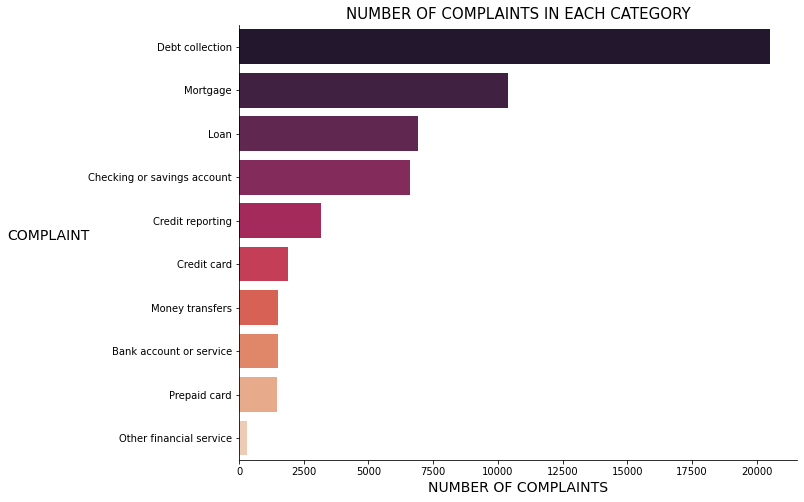

In [53]:
fig, ax = plt.subplots(figsize=(10,8))

ax = sns.countplot(y='PRODUCT', 
                   data=df_product_and_complaint_reduced, 
                   order=df_product_and_complaint_reduced['PRODUCT'].value_counts().index,
                   palette='rocket'        # change the color of this graph LATER
                  )

ax.set_title('NUMBER OF COMPLAINTS IN EACH CATEGORY',size=15)

# Setting labels
# Dealing with y-labels
ax.set_ylabel('COMPLAINT', rotation=0, labelpad=40, size=14)
              
# Dealing with x-labels
ax.set_xlabel('NUMBER OF COMPLAINTS', size=14)

sns.despine()
plt.savefig('freq_of_removed_classes_and_reduced_observations.png', transparency=True)

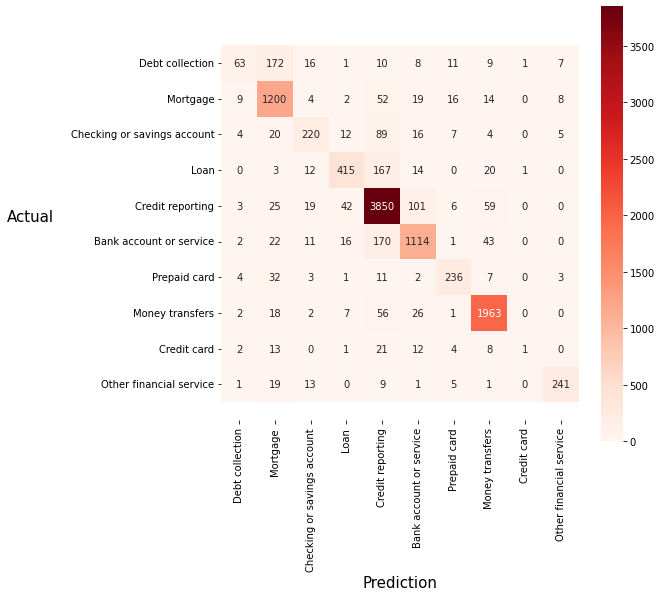

In [57]:
conf_matrix(y_test, y_pred)
plt.savefig('confusion_matrix', transparent=True)

# Section 5: Testing out Predictions on Random Complaints

In [58]:
import pandas as pd
import numpy as np
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [60]:
  with open('logit_finalized.pickle', 'rb') as to_read:  # loading our model
    logit_finalized = pickle.load(to_read)

In [65]:
complaint = """
omg where is my money
aosidnoiandnaiosdnasd This is bullshit!! where is my money!!!
I TRANSFERRED IT BUT IT JUST DISAPPEARED INTO THIN AIR.
WHAT KIND OF A BANK ARE YOU?
ARE YOU A BANK OR A THIEF?"""

# Fitting vectorized complaint into model
y_customized_prediction = logit_finalized.predict([complaint])
y_customized_prediction[0]

ValueError: Expected 2D array, got 1D array instead:
array=['\nomg where is my money\naosidnoiandnaiosdnasd This is bullshit!! where is my money!!!\nI TRANSFERRED IT BUT IT JUST DISAPPEARED INTO THIN AIR.\nWHAT KIND OF A BANK ARE YOU?\nARE YOU A BANK OR A THIEF?'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.